# Reproducibility challenge: Figure 2
### Fundamentals of Inference and Learning, EE-411
#### Thomas Lenges, Renuka Singh Virk

In this notebook, we attempt to reproduce the double descent curves from the paper "Reconciling modern machine learning practice and the bias-variance trade-of" by $\textit{Mikhail Belkin}$, $\textit{Daniel Hsu}$, $\textit{Siyuan Ma}$, $\textit{Soumik Mandal}$.

More specifically, this notebook focuses on Figure 2 of the paper.

### Mount drive

In [1]:
from google.colab import drive
import os
import sys

# Mount Google Drive
drive.mount('/content/drive', force_remount=True)

# Change the working directory to the HW2 folder
project_path = '/content/drive/My Drive/project_inference/'
os.chdir(project_path)

# Verify the current working directory
print("Current working directory:", os.getcwd())

# Add the project path to Python's module search path
sys.path.append(project_path)


Mounted at /content/drive
Current working directory: /content/drive/My Drive/project_inference


### Audio
The code below is to get a sound when a cell finishes running :)

In [2]:
from google.colab import files

# Upload your audio file (choose a .mp3 or .wav file)
uploaded = files.upload()


Saving rock.wav to rock (2).wav


In [3]:
from IPython.display import Audio, display

# Play the uploaded audio file
sound = Audio("rock.wav", autoplay=True)  # Replace 'beep.wav' with your uploaded filename

## Double descent risk curve for RFF model on MNIST.

In the following section, we reproduce the results of Figure 2 of the paper.

Section B, 'Experimental setup' of the paper provides insights on how the plots were generated.
As indicated in Figure 2, the authors of the paper used a subset of the MNIST dataset ($n=10^4$, $10$ classes).

The steps to apply are the following:
- Transform images to grayscale images (not necessary for MNIST as it is already grayscale)
- Scale the maximum range of each feature to $[0,1]$
- Perform one-hot encoding
- Subsample a training set (size $n$) uniformly at random without replacement

Note that the number of random fourier features in Figure 2 ranges from $0$ to $60000$, however our system crashes for $n=40000$ or $n=60000$, which is why we limit to $20000$. However this should be sufficient to conclude whether the figure was reproduced properly or not.

Import libraries, datasets and define useful functions:

In [4]:
# Imports
import numpy as np
import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import torch.nn.functional as F

In [5]:
# Hyperparameters
num_training_data = 10000 # Subsample size
num_test_data = 10000     # Use the full MNIST test set
num_classes = 10          # Number of classes
sigma = 5.0               # Bandwidth for Gaussian kernel (See appendix C.1)
num_rff = [50, 200, 500, 3000, 5000, 6000, 7000, 8000, 10000, 12000, 20000] # RFF dimensions
seed = 42                 # Random seed for reproducibility
np.random.seed(seed)
torch.manual_seed(seed)

In [6]:
# Data Preprocessing: Load MNIST
def preprocess_mnist():


  '''
    transform = transforms.Compose([
        transforms.ToTensor(),                      # Scale to [0, 1]
        transforms.Lambda(lambda x: x.view(-1))     # Flatten image (28x28)
    ])
    '''
  transform = transforms.Compose([transforms.ToTensor(),
                                        transforms.Normalize(
                                            (0.1307,), (0.3081,)), # Use dataset mean and std
                                        transforms.Lambda(lambda img: img.reshape(-1))
                                        ])

  # Load MNIST dataset
  mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
  mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

  # Subsample training data
  indices = np.random.choice(len(mnist_train), num_training_data, replace=False)
  train_subset = torch.utils.data.Subset(mnist_train, indices)
  train_loader = torch.utils.data.DataLoader(train_subset, batch_size=num_training_data, shuffle=False)

  test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=num_test_data, shuffle=False)

  # Extract training and test data
  x_train, y_train = next(iter(train_loader))
  x_test, y_test = next(iter(test_loader))

  # One-hot encode labels
  y_train_onehot = torch.nn.functional.one_hot(y_train, num_classes=num_classes).float()
  y_test_onehot = torch.nn.functional.one_hot(y_test, num_classes=num_classes).float()


  return x_train, y_train_onehot, x_test, y_test_onehot

x_train, y_train, x_test, y_test = preprocess_mnist()

In the code below, we model RFFs using the mathematical definition, that is:
$h(x) = \Sigma_{k=1}^{N} a_k \Phi(x;v_k)$, where $\Phi(x;v) := e^{\sqrt{-1} <v,x>}$

In [7]:
# Generate Random Fourier Features (RFF)
def generate_rff(x, D, d, sigma):
    weights = torch.randn(D, d // 2) * (1 / sigma) # Randomly sample weights from a normal distribution (scaled by 1/sigma)
    projection = x @ weights
    rff_features = torch.cat([torch.sin(projection), torch.cos(projection)], dim=-1)
    return rff_features

def train_rff(x_train, y_train, x_test, y_test, d, sigma, reg_lambda=1e-3, normalize=False):
    # Normalize input data if needed
    if normalize:
        mean, std = x_train.mean(dim=0), x_train.std(dim=0)
        x_train = (x_train - mean) / (std + 1e-8)  # Avoid divide-by-zero
        x_test = (x_test - mean) / (std + 1e-8)

    # Generate RFF features
    rff_train = generate_rff(x_train, x_train.shape[1], d, sigma)
    rff_test = generate_rff(x_test, x_train.shape[1], d, sigma)

    # Solve regularized linear system (ridge regression)
    A = rff_train.T @ rff_train + reg_lambda * torch.eye(rff_train.shape[1])
    b = rff_train.T @ y_train
    alpha = torch.linalg.solve(A, b)

    # Calculate L2 norm of weights
    l2_norm = torch.norm(alpha).item()

    # Predictions
    y_train_pred = rff_train @ alpha
    y_test_pred = rff_test @ alpha

    # Compute Zero-One Loss
    train_zero_one_loss = (torch.argmax(y_train_pred, dim=1) != torch.argmax(y_train, dim=1)).float().mean().item()
    test_zero_one_loss = (torch.argmax(y_test_pred, dim=1) != torch.argmax(y_test, dim=1)).float().mean().item()

    # Compute Squared Loss
    train_squared_loss = torch.mean((y_train_pred - y_train) ** 2).item()
    test_squared_loss = torch.mean((y_test_pred - y_test) ** 2).item()

    return train_zero_one_loss, test_zero_one_loss, train_squared_loss, test_squared_loss, l2_norm


In the cell below we provide the code for the $h_{n,\infty}$, which represents the kernel regression solution in the infinite-dimensional feature space induced by the kernel.
This value represents the best achievable value, the test loss is thus expected to tend towards it as the number of random fourier features reaches infinity.

In [8]:
'''
# Exact Gaussian Kernel
def gaussian_kernel(x1, x2, sigma):
    # Compute the squared distance between points
    sq_dists = torch.cdist(x1, x2) ** 2
    # Apply the kernel formula
    return torch.exp(-sq_dists / (2 * sigma ** 2))

def compute_h_n_infinity_test_metrics(x_train, y_train, x_test, y_test, sigma, reg_lambda=1e-3):
    # Ensure labels are one-hot encoded
    if y_train.dim() == 1:  # If not one-hot encoded
        num_classes = y_train.max().item() + 1
        y_train_one_hot = torch.zeros(len(y_train), num_classes, device=x_train.device)
        y_train_one_hot.scatter_(1, y_train.view(-1, 1), 1)
        y_train = y_train_one_hot
    if y_test.dim() == 1:  # Same for test labels
        num_classes = y_test.max().item() + 1
        y_test_one_hot = torch.zeros(len(y_test), num_classes, device=x_test.device)
        y_test_one_hot.scatter_(1, y_test.view(-1, 1), 1)
        y_test = y_test_one_hot

    # Build kernel matrices
    K_train = gaussian_kernel(x_train, x_train, sigma)
    K_test = gaussian_kernel(x_test, x_train, sigma)

    # Solve for alpha: (K^T K + λI)^{-1} K^T y
    A = K_train.T @ K_train + reg_lambda * torch.eye(K_train.shape[1], device=K_train.device)
    b = K_train.T @ y_train
    alpha = torch.linalg.solve(A, b)

    # Make predictions for test data
    y_test_pred = K_test @ alpha

    # Compute test zero-one loss
    test_zero_one_loss = (torch.argmax(y_test_pred, dim=1) != torch.argmax(y_test, dim=1)).float().mean().item()

    # Compute test squared loss
    test_squared_loss = torch.mean((y_test_pred - y_test) ** 2).item()

    # Compute L2 norm of alpha (weights)
    l2_norm = torch.norm(alpha).item()

    return test_zero_one_loss, test_squared_loss, l2_norm
'''

'\n# Exact Gaussian Kernel\ndef gaussian_kernel(x1, x2, sigma):\n    # Compute the squared distance between points\n    sq_dists = torch.cdist(x1, x2) ** 2\n    # Apply the kernel formula\n    return torch.exp(-sq_dists / (2 * sigma ** 2))\n\ndef compute_h_n_infinity_test_metrics(x_train, y_train, x_test, y_test, sigma, reg_lambda=1e-3):\n    # Ensure labels are one-hot encoded\n    if y_train.dim() == 1:  # If not one-hot encoded\n        num_classes = y_train.max().item() + 1\n        y_train_one_hot = torch.zeros(len(y_train), num_classes, device=x_train.device)\n        y_train_one_hot.scatter_(1, y_train.view(-1, 1), 1)\n        y_train = y_train_one_hot\n    if y_test.dim() == 1:  # Same for test labels\n        num_classes = y_test.max().item() + 1\n        y_test_one_hot = torch.zeros(len(y_test), num_classes, device=x_test.device)\n        y_test_one_hot.scatter_(1, y_test.view(-1, 1), 1)\n        y_test = y_test_one_hot\n\n    # Build kernel matrices\n    K_train = gaussian_k

In [9]:
display(sound)

In [10]:
# Generate results
train_zero_one_losses = []
test_zero_one_losses = []
train_squared_losses = []
test_squared_losses = []
l2_norms = []

# Compute h_{n, ∞} test metrics
#hn_inf_test_zero_one_loss, hn_inf_test_squared_loss, hn_inf_l2_norm = compute_h_n_infinity_test_metrics(x_train, y_train, x_test, y_test, sigma)


for d in num_rff:
    print(f"Training with {d} random Fourier features...")
    train_zero_one_loss, test_zero_one_loss, train_squared_loss, test_squared_loss, l2_norm = train_rff(x_train, y_train, x_test, y_test, d, sigma)
    train_zero_one_losses.append(train_zero_one_loss)
    test_zero_one_losses.append(test_zero_one_loss)
    train_squared_losses.append(train_squared_loss)
    test_squared_losses.append(test_squared_loss)
    l2_norms.append(l2_norm)

Training with 50 random Fourier features...
Training with 200 random Fourier features...
Training with 500 random Fourier features...
Training with 3000 random Fourier features...
Training with 5000 random Fourier features...
Training with 6000 random Fourier features...
Training with 7000 random Fourier features...
Training with 8000 random Fourier features...
Training with 10000 random Fourier features...
Training with 12000 random Fourier features...
Training with 20000 random Fourier features...


In [11]:
display(sound)

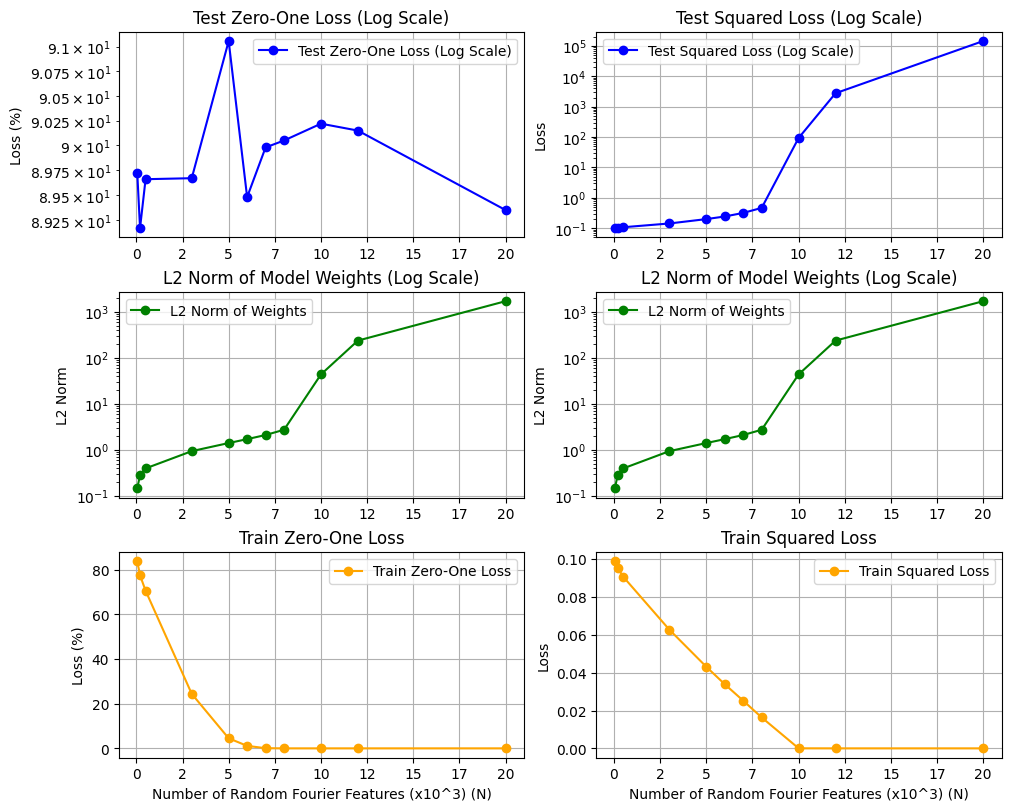

In [12]:
fig, axs = plt.subplots(3, 2, figsize=(10, 8), constrained_layout=True)
num_rff = np.array(num_rff)

# Column 1: Zero-One Loss
# Test Zero-One Loss (Log Scale)
axs[0, 0].plot(num_rff / 1000, np.array(test_zero_one_losses) * 100, label='Test Zero-One Loss (Log Scale)', marker='o', color='blue')
axs[0, 0].set_yscale('log')  # Set y-axis to logarithmic scale
axs[0, 0].set_title('Test Zero-One Loss (Log Scale)')
axs[0, 0].set_ylabel('Loss (%)')
axs[0, 0].grid()
axs[0, 0].legend()

# L2 Norms of Weights
axs[1, 0].plot(num_rff / 1000, l2_norms, label='L2 Norm of Weights', marker='o', color='green')
axs[1, 0].set_yscale('log')  # Set y-axis to logarithmic scale
axs[1, 0].set_title('L2 Norm of Model Weights (Log Scale)')
axs[1, 0].set_ylabel('L2 Norm')
axs[1, 0].grid()
axs[1, 0].legend()

# Train Zero-One Loss
axs[2, 0].plot(num_rff / 1000, np.array(train_zero_one_losses) * 100, label='Train Zero-One Loss', marker='o', color='orange')
axs[2, 0].set_title('Train Zero-One Loss')
axs[2, 0].set_xlabel('Number of Random Fourier Features (x10^3) (N)')
axs[2, 0].set_ylabel('Loss (%)')
axs[2, 0].grid()
axs[2, 0].legend()

# Column 2: Squared Loss
# Test Squared Loss (Log Scale)
axs[0, 1].plot(num_rff / 1000, test_squared_losses, label='Test Squared Loss (Log Scale)', marker='o', color='blue')
axs[0, 1].set_yscale('log')  # Set y-axis to logarithmic scale
axs[0, 1].set_title('Test Squared Loss (Log Scale)')
axs[0, 1].set_ylabel('Loss')
axs[0, 1].grid()
axs[0, 1].legend()

# L2 Norms of Weights
axs[1, 1].plot(num_rff / 1000, l2_norms, label='L2 Norm of Weights', marker='o', color='green')
axs[1, 1].set_yscale('log')  # Set y-axis to logarithmic scale
axs[1, 1].set_title('L2 Norm of Model Weights (Log Scale)')
axs[1, 1].set_ylabel('L2 Norm')
axs[1, 1].grid()
axs[1, 1].legend()

# Train Squared Loss
axs[2, 1].plot(num_rff / 1000, train_squared_losses, label='Train Squared Loss', marker='o', color='orange')
axs[2, 1].set_title('Train Squared Loss')
axs[2, 1].set_xlabel('Number of Random Fourier Features (x10^3) (N)')
axs[2, 1].set_ylabel('Loss')
axs[2, 1].grid()
axs[2, 1].legend()

# Format x-axis to show integers
for ax in axs.flatten():
    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: int(x)))

plt.show()


In [13]:
display(sound)

# Method 2: Using exact kernels
We were not able to reproduce Figure 2 with the code above, which is why we are now doing the exact computations to get better results.

In [14]:
def plot_figure_2(num_rff, test_zero_one_losses, l2_norms, train_zero_one_losses, test_squared_losses, train_squared_losses, hn, h_n_inf_test_zero_one_loss, h_n_inf_test_squared_loss, h_n_inf_l2_norm):
    fig, axs = plt.subplots(3, 2, figsize=(10, 8), constrained_layout=True)

   # Column 1: Zero-One Loss
    axs[0, 0].plot(num_rff / 1000, test_zero_one_losses * 100, label='Test Zero-One Loss (Log Scale)', marker='o', color='blue')
    #if hn:
    #  axs[0, 0].axhline(y=h_n_inf_test_zero_one_loss * 100, color='red', linestyle='--', label='$h_{n, \infty}$ Test Zero-One Loss')
    axs[0, 0].set_yscale('log')
    axs[0, 0].set_title('Test Zero-One Loss (Log Scale)')
    axs[0, 0].set_ylabel('Loss (%)')
    axs[0, 0].grid()
    axs[0, 0].legend()

    # L2 Norms of Weights
    axs[1, 0].plot(num_rff / 1000, l2_norms, label='L2 Norm of Weights', marker='o', color='green')
    if hn:
      axs[1, 0].axhline(y=h_n_inf_l2_norm, color='red', linestyle='--', label='$h_{n, \infty}$ L2 Norm')
    axs[1, 0].set_yscale('log')
    axs[1, 0].set_title('L2 Norm of Model Weights (Log Scale)')
    axs[1, 0].set_ylabel('L2 Norm')
    axs[1, 0].grid()
    axs[1, 0].legend()

    # Train Zero-One Loss
    axs[2, 0].plot(num_rff / 1000, train_zero_one_losses * 100, label='Train Zero-One Loss', marker='o', color='orange')
    axs[2, 0].set_title('Train Zero-One Loss')
    axs[2, 0].set_xlabel('Number of Random Fourier Features (x10^3) (N)')
    axs[2, 0].set_ylabel('Loss (%)')
    axs[2, 0].grid()
    axs[2, 0].legend()

    # Column 2: Squared Loss
    axs[0, 1].plot(num_rff / 1000, test_squared_losses, label='Test Squared Loss (Log Scale)', marker='o', color='blue')
    #if hn:
   #   axs[0, 1].axhline(y=h_n_inf_test_squared_loss, color='red', linestyle='--', label='$h_{n, \infty}$ Test Squared Loss')
    axs[0, 1].set_yscale('log')
    axs[0, 1].set_title('Test Squared Loss (Log Scale)')
    axs[0, 1].set_ylabel('Loss')
    axs[0, 1].grid()
    axs[0, 1].legend()

    # L2 Norms of Weights
    axs[1, 1].plot(num_rff / 1000, l2_norms, label='L2 Norm of Weights', marker='o', color='green')
    if hn:
      axs[1, 1].axhline(y=h_n_inf_l2_norm, color='red', linestyle='--', label='$h_{n, \infty}$ L2 Norm')
    axs[1, 1].set_yscale('log')
    axs[1, 1].set_title('L2 Norm of Model Weights (Log Scale)')
    axs[1, 1].set_ylabel('L2 Norm')
    axs[1, 1].grid()
    axs[1, 1].legend()

    # Train Squared Loss
    axs[2, 1].plot(num_rff / 1000, train_squared_losses, label='Train Squared Loss', marker='o', color='orange')
    axs[2, 1].set_title('Train Squared Loss')
    axs[2, 1].set_xlabel('Number of Random Fourier Features (x10^3) (N)')
    axs[2, 1].set_ylabel('Loss')
    axs[2, 1].grid()
    axs[2, 1].legend()

    plt.show()


In [15]:
# Generate RFF weights
def generate_rff_weights_torch(input_dim, num_features, bandwidth, device):
    random_weights = torch.randn(input_dim, num_features, device=device) * (1.0 / bandwidth)
    biases = torch.rand(num_features, device=device) * (2 * torch.pi)
    return random_weights, biases

# Batch-wise RFF transformation
def transform_to_rff_batch_torch(x, random_weights, biases, batch_size=1000):
    transformed = []
    scaling_factor = torch.sqrt(torch.tensor(2.0 / random_weights.size(1), device=x.device))
    for i in range(0, x.size(0), batch_size):
        batch = x[i:i + batch_size]
        projection = torch.matmul(batch, random_weights) + biases
        transformed.append(torch.cat([torch.sin(projection), torch.cos(projection)], dim=1) * scaling_factor)
    return torch.cat(transformed, dim=0)

# Train RFF-based model
def train_rff_model_torch(x_train, y_train, x_test, y_test, num_features, bandwidth, reg_lambda, device):
    input_dim = x_train.size(1)

    # Generate RFF weights
    random_weights, biases = generate_rff_weights_torch(input_dim, num_features, bandwidth, device)

    # Batch-wise RFF transformation
    z_train = transform_to_rff_batch_torch(x_train, random_weights, biases)
    z_test = transform_to_rff_batch_torch(x_test, random_weights, biases)

    # Solve ridge regression
    reg_matrix = reg_lambda * torch.eye(z_train.size(1), device=device)
    alpha = torch.linalg.solve(z_train.T @ z_train + reg_matrix, z_train.T @ y_train)

    # Predict
    y_train_pred = z_train @ alpha
    y_test_pred = z_test @ alpha

    return y_train_pred, y_test_pred, alpha

# Evaluate model
def evaluate_rff_torch(y_train_pred, y_train, y_test_pred, y_test):
    # Compute MSE
    mse_train = torch.mean((y_train_pred - y_train) ** 2).item()
    mse_test = torch.mean((y_test_pred - y_test) ** 2).item()

    # Compute classification accuracy
    train_accuracy = (torch.argmax(y_train_pred, dim=1) == torch.argmax(y_train, dim=1)).float().mean().item()
    test_accuracy = (torch.argmax(y_test_pred, dim=1) == torch.argmax(y_test, dim=1)).float().mean().item()

    return mse_train, mse_test, train_accuracy, test_accuracy


def compute_h_n_infinity_torch(x_train, y_train, x_test, y_test, bandwidth, reg_lambda, device):
    # Ensure tensors are on the correct device
    x_train, y_train = x_train.to(device), y_train.to(device)
    x_test, y_test = x_test.to(device), y_test.to(device)

    # Compute exact kernel matrices
    pairwise_sq_dists_train = torch.cdist(x_train, x_train) ** 2
    pairwise_sq_dists_test = torch.cdist(x_test, x_train) ** 2
    K_train = torch.exp(-pairwise_sq_dists_train / (2 * bandwidth**2))
    K_test = torch.exp(-pairwise_sq_dists_test / (2 * bandwidth**2))

    # Solve for alpha: (K_train + λI)^-1 Y_train
    reg_matrix = reg_lambda * torch.eye(K_train.size(0), device=device)
    alpha = torch.linalg.solve(K_train + reg_matrix, y_train)

    # Predictions for test data
    y_test_pred = torch.matmul(K_test, alpha)

    # Compute test zero-one loss
    test_zero_one_loss = 1 - (
        torch.argmax(y_test_pred, dim=1) == torch.argmax(y_test, dim=1)
    ).float().mean().item()

    # Compute test squared loss
    test_squared_loss = torch.mean((y_test_pred - y_test) ** 2).item()

    # Compute L2 norm of alpha
    l2_norm = torch.norm(alpha).item()

    return test_zero_one_loss, test_squared_loss, l2_norm


# Run and plot RFF experiment
def run_rff_experiment_torch_with_hninf(x_train, y_train, x_test, y_test, device, bandwidth=sigma, reg_lambda=0.001):
    # Move data to the correct device
    x_train = x_train.to(device)
    y_train = y_train.to(device)
    x_test = x_test.to(device)
    y_test = y_test.to(device)

    # Parameters
    num_features_list = [1, 50, 200, 500, 2000, 3000, 5000, 6000, 7000, 8000, 10000, 15000, 20000]

    # Initialize lists for metrics
    train_zero_one_losses = []
    test_zero_one_losses = []
    train_squared_losses = []
    test_squared_losses = []
    l2_norms = []

    # Compute h_{n,∞} for reference
    h_n_inf_test_zero_one_loss, h_n_inf_test_squared_loss, h_n_inf_l2_norm = compute_h_n_infinity_torch(
        x_train, y_train, x_test, y_test, bandwidth, reg_lambda, device
    )

    # Run experiments for different numbers of RFF features
    for num_features in num_features_list:
        print(f"Training with {num_features} RFF features...")

        # Subsample data for large RFF experiments
        if num_features > 5000:
            x_train_subsample = x_train[:10000]
            y_train_subsample = y_train[:10000]
        else:
            x_train_subsample = x_train
            y_train_subsample = y_train

        y_train_pred, y_test_pred, alpha = train_rff_model_torch(
            x_train_subsample, y_train_subsample, x_test, y_test, num_features, bandwidth, reg_lambda, device
        )

        # Evaluate
        mse_train, mse_test, train_accuracy, test_accuracy = evaluate_rff_torch(
            y_train_pred, y_train_subsample, y_test_pred, y_test
        )
        train_zero_one_losses.append(1 - train_accuracy)
        test_zero_one_losses.append(1 - test_accuracy)
        train_squared_losses.append(mse_train)
        test_squared_losses.append(mse_test)
        l2_norms.append(torch.norm(alpha).item())

    # Convert lists to NumPy arrays for plot
    num_rff = torch.tensor(num_features_list, device=device).cpu().numpy()
    train_zero_one_losses = np.array(train_zero_one_losses)
    test_zero_one_losses = np.array(test_zero_one_losses)
    train_squared_losses = np.array(train_squared_losses)
    test_squared_losses = np.array(test_squared_losses)
    l2_norms = np.array(l2_norms)

    return num_rff, train_zero_one_losses, test_zero_one_losses, train_squared_losses, test_squared_losses, l2_norms, h_n_inf_test_zero_one_loss, h_n_inf_test_squared_loss, h_n_inf_l2_norm


In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_rff, train_zero_one_losses, test_zero_one_losses, train_squared_losses, test_squared_losses, l2_norms, h_n_inf_test_zero_one_loss, h_n_inf_test_squared_loss, h_n_inf_l2_norm = run_rff_experiment_torch_with_hninf(x_train, y_train, x_test, y_test, device)

Training with 1 RFF features...
Training with 50 RFF features...
Training with 200 RFF features...
Training with 500 RFF features...
Training with 2000 RFF features...
Training with 3000 RFF features...
Training with 5000 RFF features...
Training with 6000 RFF features...
Training with 7000 RFF features...
Training with 8000 RFF features...
Training with 10000 RFF features...
Training with 15000 RFF features...
Training with 20000 RFF features...


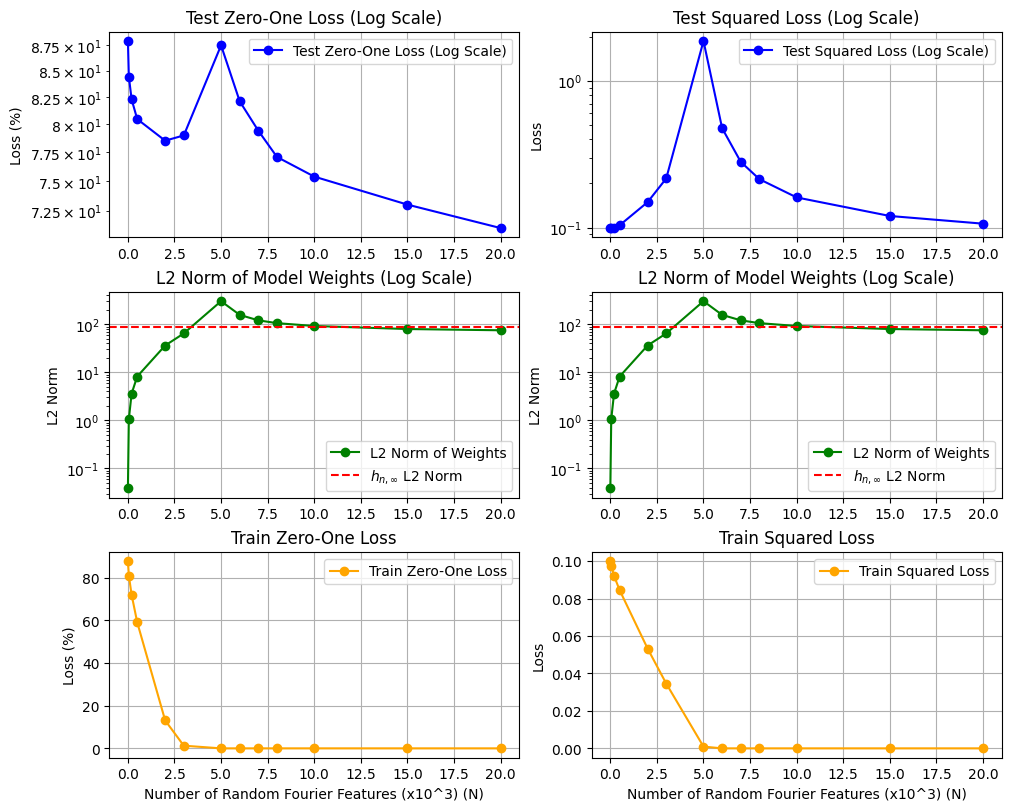

In [17]:
plot_figure_2(num_rff, test_zero_one_losses, l2_norms, train_zero_one_losses, test_squared_losses, train_squared_losses, True, h_n_inf_test_zero_one_loss, h_n_inf_test_squared_loss, h_n_inf_l2_norm)

In [18]:
display(sound)